# Monte-carlo simulations

Xrmc (monte-carlo) + xmim-sim (detector response) + xraylib (cross sections) is used for simulation. The sample reference frame is defined as:
 * Z-axis: beam direction
 * X-axis: horizontal and pointing to the right when looking upstream
 * Y-axis: vertical and pointing upwards
 * Origin: beam goes through it
 
 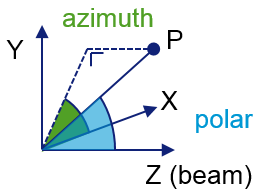

The position of sample and detectors is defined in a spherical coordinates (distance, polar, azimuth) within the sample reference frame. By default the sample surface is the XY-plane, the origin is the point where the beam hits the sample and the sample is centered on the beam. Detector are positioned in transmission by default (polar and azimuthal angles set to zero and positive distance).

Units in this notebook are
 * cm (distance)
 * degrees (angle)
 * keV (energy)
 * seconds (time)
 
 Define the experiments that you want to run:

In [1]:
from spectrocrunch.simulation.xrmc import XrmcWorldBuilder, loadxrmcresult, showxrmcresult
import numpy as np
import matplotlib.pyplot as plt
import os
homedir = os.path.expanduser("~")
root = os.path.join(homedir, 'xrmcdata')
try:
    os.makedirs(root)
except OSError:
    pass

def addnoise(cts):
    return np.random.poisson(np.round(cts).astype(int))

# MODIFY:
experiments = ['xanes', 'imaging', 'yield', 'xrfdl', 'xrfmulti', 'calcdt']
#experiments = ['xrfmulti']

## Table of content:
* [Measurements](#measured-data)
* [Source](#source)
* [Detectors](#detectors)
* [Samples](#sample)
* [Experiments](#experiments)
    * [Imaging](#imaging)
    * [XANES](#xanes)
    * [XRF Dead time](#dead-time)
    * [XRF/scatter yield](#xrf-yield)
    * [XRF detection limit](#xrf-dl)
    * [XRF multi-element](#xrf-multi)

## Measured data <a class="anchor" id="measured-data"></a>

### Spectrum

Experimental spectrum and geometry

In [2]:
from spectrocrunch.geometries import qxrf
from spectrocrunch.io import xiaedf
from spectrocrunch.io import spec

def load_xrf(name=None):
    if name == 'axo':
        # Calibrate diodes
        params = {'base': '/data/id21/store/backup_visitor/2018/me1494/id21',
                  'sample': 'standards',
                  'dataset': 'spec01',
                  'gaindiodeI0': 1e8,
                  'dark': False,
                  'fixdark': True,
                  'plot': False}
        scans = [{'specnr':105, 'resetdevices': True},
                 {'specnr':106},
                 {'specnr':107}]
        geom = qxrf.factory('sxm')
        geom.batchcalibrate_diodes(params, scans)

        # Load data
        path = '/data/id21/store/backup_visitor/2018/me1494/id21/standards/standards_0007/zap'
        radix = 'standards_0007'
        mapnum = 92
        geom.diodeI0.gain = 1e8
        detectorposition = -23
        xiaimg = xiaedf.xiaimage_number(path,radix,mapnum)
        xiaimg.dtcor(True)
        xiaimg.detectorsum(True)
    else:
        return None
    # Load scan info
    h = xiaimg.header(source='counters')
    parseinfo = geom.instrument.edfparser_info()
    parser = spec.edfheader_parser(**parseinfo)
    h = parser.parse(h)
    
    # Sum spectrum at particular flux and time
    ctridx = xiaimg.counternames().index('arr_iodet')
    I0 = xiaimg.counters[..., ctridx, 0]
    geom.reference = np.nanmedian(I0)
    geom.xrf_positions = [detectorposition]

    energy = h['energy'].to('keV').magnitude
    xrfnormop,refflux,reftime,expotime = geom.xrfnormop(energy,
                                                        expotime=h['time'])
    norm = xrfnormop(I0)[..., np.newaxis]
    mca = xiaimg.data[..., 0]/norm
    reftime *= mca.shape[0]*mca.shape[1]
    mca = mca.sum(axis=(0, 1))
    sourceparams = {'time': reftime, 'flux': refflux, 'energy': energy}
    return {'mca': mca, 'geometry':geom.xrfgeometry, 'source':sourceparams}

  File "/sware/exp/spectrocrunch/2019xrmc_debian8/venv/local/lib/python2.7/site-packages/silx/gui/qt/_qt.py", line 96, in <module>
    since_version='0.9.0')


### Dead time

Experimental dead time per pulse (sec) derived from ICR and OCR assuming paralyzable deadtime

In [3]:
def load_pulseproctime():
    path = '/data/id21/store/backup_visitor/2018/me1494/id21/LSCF_SDC_72h/LSCF_SDC_72h_mappaprova/zap'
    radix = 'LSCF_SDC_72h_mappaprova'
    mapnum = 1
    xiaimg = xiaedf.xiaimage_number(path,radix,mapnum)
    icr, ocr = xiaimg.stats[...,0].T
    icr = icr.flatten()
    ocr = ocr.flatten()
    dtfrac = (icr-ocr)/icr.astype(float)
    return np.nanmedian(-np.log(1-dtfrac)/icr)

## Source <a class="anchor" id="source"></a>

Energy, flux and exposure time have default values but can be changed. The beamsize is either 100 um (fullfield) or 1 um.

In [4]:
from spectrocrunch.sources import xray as xraysources
from spectrocrunch.materials import pymca

def define_source(source=None, energy=7.5, flux=1e10, time=0.1, **kwargs):
    if source is None:
        source = xraysources.factory("synchrotron")
    pymcahandle = pymca.PymcaHandle(energy=energy,
                                    flux=flux,
                                    time=time,
                                    linear=True,
                                    escape=True,
                                    snip=True,
                                    scatter=True,
                                    **kwargs)
    return source, pymcahandle

def world_addsource(world, pymcahandle, beamsize=None, fullfield=False):
    distance = 42e2  # doesn't really matter
    # Beamsize at the sample
    if beamsize is None:
        if fullfield:
            beamsize = 100e-4  # cm
        else:
            beamsize = 1e-4  # cm
    world.definesource(flux=pymcahandle.flux.to('Hz').magnitude,
                       energy=pymcahandle.energy,
                       distance=distance,
                       beamsize=beamsize)

def printsummary(pymcahandle):
    print(pymcahandle.sample)
    print('Energy = {} '.format(pymcahandle.energy))
    print('Flux = {:~.01e}'.format(pymcahandle.flux))
    print('Time = {:~}'.format(pymcahandle.time))

## Detectors <a class="anchor" id="detectors"></a>

The position of a detector is defined in a spherical coordinate system (distance, polar, azimuth) within the sample reference frame.

### Diode

In [5]:
def world_adddiode(world, distance=10, polar=0, azimuth=0,
                   activearea=1, multiplicity=10, geometry=None):
    forcedetect = False
    poissonnoise = False
    if geometry is not None:
        distance = geometry.distance.to('cm').magnitude
        activearea = geometry.detector.activearea.to('cm**2').magnitude
        polar = geometry.anglein + geometry.angleout
        azimuth = geometry.azimuth
    world.adddiode(distance=distance, polar=polar, azimuth=azimuth,
                   activearea=activearea,
                   poissonnoise=poissonnoise, ebinsize=None,
                   forcedetect=forcedetect, multiplicity=multiplicity,
                   time=pymcahandle.time.to('s').magnitude)

### XRF detector


In [6]:
from spectrocrunch.materials import multilayer
from spectrocrunch.detectors import xrf as xrfdetectors
from spectrocrunch.geometries import xrf as xrfgeometries

def define_xrfgeometry(source):
    detector = xrfdetectors.factory("leia")
    geometry = xrfgeometries.factory("sxm120",
                                     detector=detector,
                                     source=source)
    #geometry.detector.removebeamfilters()
    #geometry.detector.removedetectorfilters()
    return geometry

def world_addsdd(world, geometry, distance=None, polar=None,
                 azimuth=None, activearea=None,
                 hoffset=0, voffset=0, convoluted=False,
                 pulseproctime=0, multiplicity=10,
                 emin = None, emax = None):
    forcedetect = True
    poissonnoise = False
    ebinsize = geometry.detector.mcagain  # keV
    if distance is None:
        distance = geometry.distance.to('cm').magnitude
    if activearea is None:
        activearea = geometry.detector.activearea.to('cm**2').magnitude
    if polar is None:
        polar = geometry.anglein + geometry.angleout
    if azimuth is None:
        azimuth = geometry.azimuth
    if convoluted:
        detectormaterial = geometry.detector.material
        detectorthickness = geometry.detector.thickness
        detectormaterial = world.addmaterial(detectormaterial)
        
        window = geometry.detector.detectorfilters()
        material = [w['material'] for w in window]
        thickness = [w['thickness'] for w in window]
        if material:
            windowmaterial = multilayer.Multilayer(material=material,
                                                   thickness=thickness,
                                                   name='sddwindow')
            windowthickness = sum(windowmaterial.thickness)
            windowmaterial = windowmaterial.mixlayers()
            windowmaterial = world.addmaterial(windowmaterial)
        else:
            windowmaterial = 'vacuum'
            windowthickness = 0
            windowmaterial = world.addmaterial(windowmaterial)

        response = {'material': detectormaterial,
                    'thickness': detectorthickness,
                    'windowmaterial': windowmaterial,
                    'windowthickness': windowthickness,
                    'noise': geometry.detector.mcanoise,
                    'fano': geometry.detector.mcafano,
                    'pulseproctime': pulseproctime}
    else:
        response = {}
    world.addxrfdetector(distance=distance, activearea=activearea,
                         polar=polar, azimuth=azimuth,
                         hoffset=hoffset, voffset=voffset,
                         emin=emin, emax=emax,
                         ebinsize=ebinsize, poissonnoise=poissonnoise,
                         forcedetect=forcedetect, multiplicity=multiplicity,
                         response=response, time=pymcahandle.time.to('s').magnitude)
    if convoluted:
        geometry.detector.mcagain = world.detector.mcagain
        geometry.detector.mcazero = world.detector.mcazero

### Imaging camera

In [7]:
def world_addpco(world, distance=5, polar=None,
                 azimuth=None, n=128, multiplicity=10):
    forcedetect = True
    poissonnoise = False
    ebinsize = 5e-3  # keV
    projbeamsizetrans = 2 * (world.source.distance + distance) * np.tan(world.source.divergence)
    pixelsize = projbeamsizetrans/n  # beam fits exactly in detector (when polar,azimuth = 0,0)
    world.addareadetector(distance=distance, polar=polar, azimuth=azimuth,
                          pixelsize=(pixelsize, pixelsize), dims=(n, n),
                          ebinsize=ebinsize, poissonnoise=poissonnoise,
                          forcedetect=forcedetect, multiplicity=multiplicity,
                          time=pymcahandle.time.to('s').magnitude)

## Sample <a class="anchor" id="sample"></a>

Multilayered sample centered on the beam and its surface going through the origin of the sample reference frame. Rotations can be applied similar to detectors (polar and azimuth in sample reference frame).

In [8]:
from spectrocrunch.materials import compoundfromformula
from spectrocrunch.materials import compoundfromdb
from spectrocrunch.materials import compoundfromlist
from spectrocrunch.materials import element
from spectrocrunch.materials import mixture
from spectrocrunch.materials import types
from spectrocrunch.materials import xrfstandards
from spectrocrunch.materials import xrayspectrum

# All pre-defined compounds:
#print(compoundfromdb.getnames())
# Search in pre-defined compounds:
#print(compoundfromdb.search('ferric'))

def define_sample(geometry, name=None):
    if name == 'cell':
        cell = compoundfromdb.compoundfromdb('ecoli dry')
        substrate = compoundfromdb.compoundfromdb("silicon nitride")
        # Dope cell with elements (1e-6 = 1 ppm)
        cell.addelements(['Ce'], [100e-6], types.fraction.mole)
        # Add sample cover
        ultralene = compoundfromdb.compoundfromdb("ultralene")
        attenuators = [["SampleCover", ultralene, 4.064e-4],
                       ["BeamFilter0", ultralene, 4.064e-4]]
        for k in attenuators:
            geometry.addattenuator(*k)
        # Multilayer of cell on substrate
        sample = multilayer.Multilayer(material=[cell, substrate],
                                       thickness=[10e-4, 0.2e-4],
                                       geometry = geometry,
                                       name = 'cell')
    elif name == 'plant':
        plant = compoundfromdb.compoundfromdb('Cellulose Nitrate')
        # Dope cell with elements (1e-6 = 1 ppm)
        elements = ['Ce', 'P', 'S', 'Cl', 'K', 'Ca', 'Mn', 'Fe']
        mfracs = [200e-6, 2000e-6, 1000e-6, 100e-6, 10000e-6, 5000e-6, 50e-6, 100e-6]
        plant.addelements(elements, mfracs, types.fraction.mole)
        # Add sample cover
        ultralene = compoundfromdb.compoundfromdb("ultralene")
        attenuators = [["SampleCover", ultralene, 4.064e-4],
                       ["BeamFilter0", ultralene, 4.064e-4]]
        for k in attenuators:
            geometry.addattenuator(*k)
        # Multilayer of cell on substrate
        sample = multilayer.Multilayer(material=[plant, ultralene],
                                       thickness=[20e-4, 4.064e-4],
                                       geometry = geometry,
                                       name = 'plant')
    elif name == 'imaging':
        c1 = compoundfromdb.compoundfromdb("hematite")
        c2 = compoundfromformula.CompoundFromFormula("PbSO4",
                                                     density=6.29)
        c3 = compoundfromlist.CompoundFromList(["Ca","C","O"],
                                               [1,1,3],
                                               types.fraction.mole,
                                               density=2.71,
                                               name="calcite")
        toplayer = c1
        substrate = mixture.Mixture([c2,c3],
                                    [1,1],
                                    types.fraction.mass,
                                    name="Substrate")
        sample = multilayer.Multilayer(material=[toplayer, substrate],
                                       thickness=[10e-4, 20e-4],
                                       geometry = geometry,
                                       name = 'imaging')
    elif name == 'axo':
        sample = xrfstandards.factory("id21_room",
                                      geometry=geometry,
                                      filmthickness=1e-7,
                                      extraelements=["Ni","Cl","Cr","Al"])
    else:
        c1 = compoundfromdb.compoundfromdb("hematite")
        c2 = compoundfromformula.CompoundFromFormula("PbSO4",
                                                     density=6.29)
        c3 = compoundfromlist.CompoundFromList(["Ca","C","O"],
                                               [1,1,3],
                                               types.fraction.mole,
                                               density=2.71,
                                               name="calcite")
        homogen = mixture.Mixture([c1,c2,c3],
                                  [1,1,1],
                                  types.fraction.mass,
                                  name="mixture")
        sample = multilayer.Multilayer(material=[homogen],
                                       thickness=[30e-4],
                                       geometry=geometry,
                                       name='simple')
    return sample

def world_addsample(world, sample, fullfield=False):
    projbeamsizesample = 2 * (world.source.distance) * np.tan(world.source.divergence)
    assert world.source.beamsize == projbeamsizesample
    if fullfield:
        # Make sure the entire sample fits in the beam footprint
        samplesize = projbeamsizesample/2.
    else:
        # Make sure the sample is larger than the beam footprint
        samplesize = max(projbeamsizesample*10, 0.5)
    
    # All layers the same size and beam throught sample center
    nlayers = len(sample)
    dxs = [samplesize]*nlayers
    dys = [samplesize]*nlayers
    oxs = [0]*nlayers
    oys = [0]*nlayers
    
    if sample.name == 'imaging':
        # Make first layer smaller
        dxs[0] = 3*samplesize/4.
        dys[0] = samplesize/4.
        oxs[0] = (samplesize-dxs[0])/2.
        oys[0] = 0#-(samplesize-dys[0])/2.
    
    world.removesample()
    for layer, dx, dy, ox, oy in zip(sample, dxs, dys, oxs, oys):
        world.addlayer(material=layer.material,
                       thickness=layer.thickness,
                       dhor=dx, dvert=dy, ohor=ox, overt=oy)
    return sample

## Run experiments <a class="anchor" id="experiments"></a>

In [9]:
from spectrocrunch.io import localfs

def run(world, interactions, simulate=True, plot=True, ylog=False):
    path = localfs.Path(world.main.path)
    if simulate:
        path.remove(recursive=True)
        world.finalize(interactions=interactions)
        if not world.simulate():
            #path.ls(recursive=True)
            raise RuntimeError('Simulation failed')
    else:
        world.finalize(interactions=interactions)
    #if plot:
    #    path.ls(recursive=True)
    data, info = loadxrmcresult(world.detector.outpath, world.detector.name)
    if plot:
        #info.pop('xenergy') # in case you want channels
        showxrmcresult(data, ylog=ylog, **info)
    return data, info

## Imaging <a class="anchor" id="imaging"></a>

Visualize sample in transmission with a wide beam and an area detector. Test sample and detector rotation. Before transformation, the detector is centered in transmission, looking upstream at the sample. Image X and Y axes parallel to the sample X and Y axes.

Multilayer (ordered top-bottom):
 Layer 0. 10.0 um (hematite)
 Layer 1. 20.0 um (50.00 wt% PbSO4 + 50.00 wt% calcite)
Energy = 7.5 
Flux = 1.0e+10 Hz
Time = 0.1 s
Data shape: (1, 1, 128, 128, 1701)
Step 0
 Min counts/pixel (for each order): [0.]
 Max counts/pixel (for each order): [61031.83372217]
 Total counts (for each order): [6.07937159e+08]


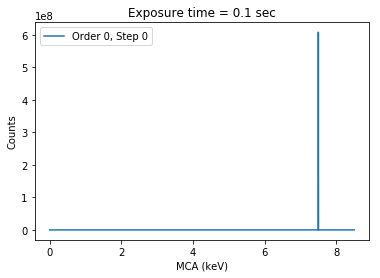

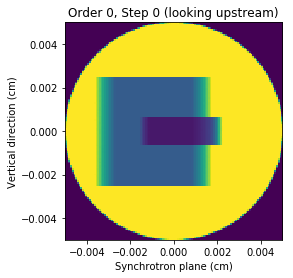

In [10]:
if 'imaging' in experiments:
    # MODIFY:
    samplename = 'imaging'
    
    path = os.path.join(root, 'imaging')
    world = XrmcWorldBuilder(path)
    source, pymcahandle = define_source()
    pymcahandle.sample = define_sample(None, name=samplename)
    printsummary(pymcahandle)
    world_addsource(world, pymcahandle, fullfield=True)
    world_addpco(world)
    world_addsample(world, pymcahandle.sample, fullfield=True)
    # Detector position:
    world.detector.polar = 0  # degrees
    world.detector.azimuth = 0  # degrees
    world.detector.hoffset = 0  # cm
    world.detector.voffset = 0  # cm
    world.detector.hpoffset = 0  # pixels
    world.detector.vpoffset = 0  # pixels
    # Sample orientation:
    world.quadrics.polar = 28  # degrees
    world.quadrics.azimuth = 180  # degrees
    # Multiple sample orientations:
    #world.quadrics.add_Zrotationloop(90, 1) # outer loop
    #world.quadrics.add_Yrotationloop(90, 1) # inner loop
    data, info = run(world, (10, ), simulate=True)

## XANES <a class="anchor" id="xanes"></a>
Transmission: diode behind the sample, fluorescence: diode at 110 degrees from the beam (in the synchrotron plane).

Multilayer (ordered top-bottom):
 Layer 0. 30.0 um (33.33 wt% PbSO4 + 33.33 wt% calcite + 33.33 wt% hematite)
Energy = 7.5 
Flux = 1.0e+10 Hz
Time = 0.1 s


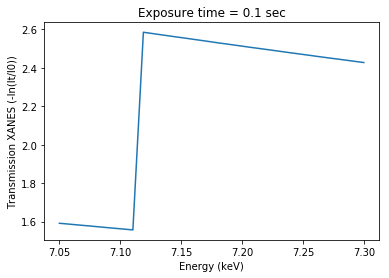

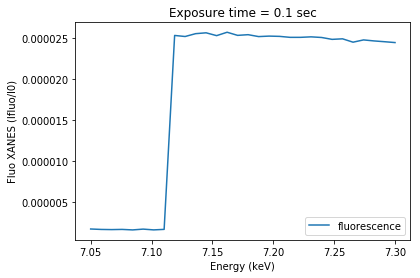

In [11]:
if 'xanes' in experiments:
    # MODIFY:
    energy = np.linspace(7.05, 7.3, 30)
    samplename = 'simple'
    
    path = os.path.join(root, 'xanes')
    world = XrmcWorldBuilder(path)
    source, pymcahandle = define_source()
    pymcahandle.sample = define_sample(None, name=samplename)
    world_addsource(world, pymcahandle)
    world_adddiode(world)
    world_addsample(world, pymcahandle.sample)
    
    printsummary(pymcahandle)
    for fluo in [False, True]:
        if fluo:
            label = 'fluorescence'
            world.path = os.path.join(root, 'fxanes')
            world.detector.forcedetect = True
            world.detector.polar = 110  # degrees
            multiplicity = 0, 100
        else:
            # Do not force detection to get the 0-order (transmission).
            label = 'transmission'
            world.path = os.path.join(root, 'txanes')
            world.detector.forcedetect = False
            world.detector.polar = 0
            multiplicity = (1,)
        # Simulate at each XANES energy:
        counts = np.zeros(energy.size)
        for i, en in enumerate(energy):
            world.spectrum.lines[0][0] = en
            data, info = run(world, multiplicity, simulate=True, plot=False)
            counts[i] = np.squeeze(data[int(fluo)])
        I0 = np.full_like(counts, pymcahandle.I0)
        normcounts = addnoise(counts)/addnoise(I0).astype(float)
        if not fluo:
            normcounts = -np.log(normcounts)
        # Plot XANES spectra
        plt.figure()
        tmp = plt.plot(energy, normcounts, label=label)
        plt.xlabel('Energy (keV)')
        if fluo:
            plt.ylabel('Fluo XANES (Ifluo/I0)')
        else:
            plt.ylabel('Transmission XANES (-ln(It/I0))')
        plt.title('Exposure time = {} sec'.format(info['time']))
    tmp = plt.legend()

## Dead time <a class="anchor" id="dead-time"></a>

Explore monte-carlo simultation of deadtime (paralyzable deadtime without pile-up rejection).

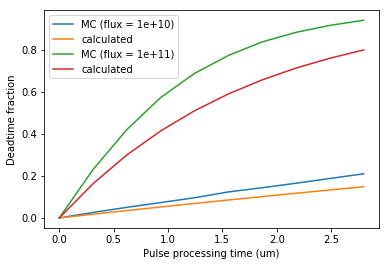

In [12]:
if 'calcdt' in experiments:
    # MODIFY:
    samplename = 'plant'

    for flux in [1e10, 1e11]:
        for sdd in False, True:
            path = os.path.join(root, 'calcdt')
            world = XrmcWorldBuilder(path)
            measurement = load_xrf(name=samplename)
            source, pymcahandle = define_source(energy=7.2, flux=flux, time=1, emin=0)
            geometry = define_xrfgeometry(source=source)
            pymcahandle.emax = pymcahandle.energy+1
            pymcahandle.ninteractions = 1
            pymcahandle.sample = define_sample(geometry, name=samplename)
            world_addsource(world, pymcahandle)
            if sdd:
                world_addsdd(world, geometry,
                             pulseproctime=0,
                             multiplicity=10,
                             convoluted=True)
            else:
                world_adddiode(world, geometry=geometry)

            world_addsample(world, pymcahandle.sample)

            if sdd:
                multiplicity = (0,) + (10000,) * pymcahandle.ninteractions
                ocr = []
                pulseproctimes = np.linspace(0, 2.8e-6, 10)
                for pulseproctime in pulseproctimes:
                    world.detector.set_pulseproctime(None, None, pulseproctime=pulseproctime)
                    data, info = run(world, multiplicity, simulate=True,
                                     ylog=True, plot=False)
                    ocr.append(data.sum()/info['time'])
                ocr = np.asarray(ocr)
            else:
                multiplicity = (0,) + (100,) * pymcahandle.ninteractions
                world.detector.forcedetect = True
                data, info = run(world, multiplicity, simulate=True,
                                     ylog=True, plot=False)
                icr = data.sum()/info['time']
        icr = np.full_like(ocr, ocr[0])
        dtfrac = (icr-ocr)/icr
        plt.plot(pulseproctimes*1e6, dtfrac, label='MC (flux = {:.0e})'.format(flux))
        plt.plot(pulseproctimes*1e6, 1-np.exp(-pulseproctimes*icr), label='calculated')
    plt.xlabel('Pulse processing time (um)')
    plt.ylabel('Deadtime fraction')
    plt.legend()
    plt.savefig(os.path.join(path, 'deadtime.png'), dpi=200)

## XRF: yield <a class="anchor" id="xrf-yield"></a>

Yield of scattering and fluorescence as function of detector position

In [13]:
if 'yield' in experiments:
    # MODIFY:
    polar_start, polar_end, polar_nsteps = 0, 180, 30
    azimuth = 0, 45, 90
    fluoline = element.Element('Ca').fluolines('KL3')
    
    polar = np.linspace(polar_start, polar_end, polar_nsteps+1)
    path = os.path.join(root, 'yield')
    world = XrmcWorldBuilder(path)
    source, pymcahandle = define_source()
    geometry = define_xrfgeometry(source=source)
    pymcahandle.sample = define_sample(geometry, name='simple')
    world_addsource(world, pymcahandle)
    world_addsdd(world, geometry,
                 multiplicity=10,
                 polar=polar_start,
                 azimuth=azimuth[0],
                 convoluted=False)
    world_addsample(world, pymcahandle.sample)
    
    polar_step = float(polar_end-polar_start)/polar_nsteps
    result = {}
    for az in azimuth:
        world.main.removeloops()
        world.detector.azimuth = az
        world.detector.add_polarrotationloop(polar_step, polar_nsteps)
        data, info = run(world, (1, 10000, ), simulate=True,
                         ylog=True, plot=False)
        
        result[az] = data

Plot yield as function of detector position

Multilayer (ordered top-bottom):
 Layer 0. 30.0 um (33.33 wt% PbSO4 + 33.33 wt% calcite + 33.33 wt% hematite)
Energy = 7.5 
Flux = 1.0e+10 Hz
Time = 0.1 s


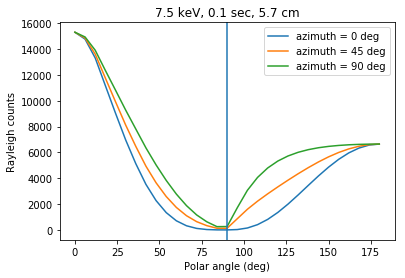

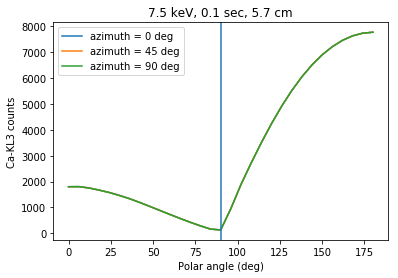

In [14]:
if 'yield' in experiments:

    def plotyield(line, nbin=1):
        plt.figure()
        for az, data in sorted(result.items(), key=lambda x: x[0]):
            y = np.array(polar)
            for i, angle in enumerate(polar):
                idx = np.argmin(np.abs(info['xenergy']-line.energy(polar=angle)))
                y1 = data[1, i, 0, 0, idx-nbin//2:idx+nbin//2+1]
                y[i] = y1.sum(axis=-1)
            tmp = plt.plot(polar, y, label='azimuth = {:.0f} deg'.format(az))
        plt.xlabel('Polar angle (deg)')
        plt.ylabel(str(line)+' counts')
        plt.legend()
        tmp = plt.title('{} keV, {} sec, {:~}'.format(pymcahandle.energy,
                                                      info['time'],
                                                      pymcahandle.sample.geometry.distance.to('cm')))
        plt.axvline(x=90)
    
    printsummary(pymcahandle)
    rayleighline = xrayspectrum.RayleighLine(pymcahandle.energy)
    comptonline = xrayspectrum.ComptonLine(pymcahandle.energy)
    for line in [rayleighline, fluoline]:
        plotyield(line)

## XRF: detection limits <a class="anchor" id="xrf-dl"></a>

Monte-carlo simulation of one XRF spectrum

Multilayer (ordered top-bottom):
 Layer 0. 20.0 um (Cellulose Nitrate)
 Layer 1. 4.064 um (ultralene)
Energy = 7.5 
Flux = 1.0e+10 Hz
Time = 0.1 s
Data shape: (2, 1, 1, 1, 1701)
Step 0
 Min counts/pixel (for each order): [0.         0.02396174]
 Max counts/pixel (for each order): [ 0.         57.26074384]
 Total counts (for each order): [   0. 4577.]


/sware/exp/spectrocrunch/2019xrmc_debian8/venv/local/lib/python2.7/site-packages/matplotlib/ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


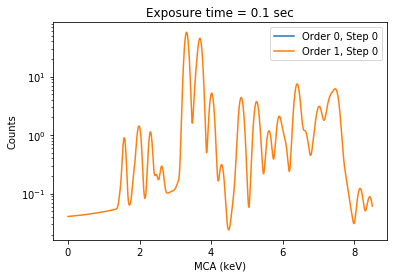

In [15]:
if 'xrfdl' in experiments:
    # MODIFY:
    samplename = 'plant'
    elements = ['Ce']
    
    path = os.path.join(root, 'xrfdl')
    world = XrmcWorldBuilder(path)
    measurement = load_xrf(name=samplename)
    #pulseproctime = load_pulseproctime()
    pulseproctime = -np.log(1-0.8)/1e6 # 80%DT at 1e6 counts/sec
    if measurement:
        geometry = measurement['geometry']
        source, pymcahandle = define_source(source=geometry.source,
                                            **measurement['source'])
    else:
        source, pymcahandle = define_source()
        geometry = define_xrfgeometry(source=source)
    pymcahandle.emax = pymcahandle.energy + 1
    pymcahandle.ninteractions = 1
    pymcahandle.sample = define_sample(geometry, name=samplename)
    world_addsource(world, pymcahandle)
    world_addsdd(world, geometry,
                 pulseproctime=pulseproctime,
                 multiplicity=10,
                 convoluted=True,
                 emax = pymcahandle.emax)
    world_addsample(world, pymcahandle.sample)
    multiplicity = (0,) + (10000,) * pymcahandle.ninteractions
    printsummary(pymcahandle)
    data, info = run(world, multiplicity, simulate=True,
                     ylog=True, plot=True)
    #ax = plt.gca()
    #ax.set_ylim([0.1, data.max()*10])
    spectra = {}
    spectra['MC'] = {'mca': data[:, 0, 0, 0, :].sum(axis=0),
                     'energy': info['xenergy']}
    spectra['MCpoisson'] = {'mca': addnoise(spectra['MC']['mca']),
                            'energy': info['xenergy']}

Fit XRF spectrum with pymca

In [16]:
from copy import deepcopy
import difflib

if 'xrfdl' in experiments:
    pymcahandle.setdata(spectra['MC']['mca'])
    pymcahandle.linear = False
    pymcahandle.snip = True
    geometry.detector.bltail = False
    geometry.detector.bstail = False
    geometry.detector.bstep = False
    geometry.detector.ratios = 0.05, 0.1 , 0.1
    geometry.detector.stailslope_ratio = 0.05
    geometry.detector.ltailslope_ratio = 0.1
    pymcahandle.addtopymca(fresh=True)
    pymcahandlefit = deepcopy(pymcahandle)
    try:
        environ_elements = pymcahandlefit.sample.extraelements
    except AttributeError:
        environ_elements = None
    fitresult = pymcahandlefit.fit(loadfromfit=True, environ_elements=environ_elements)
    
    #d = difflib.Differ()
    #diff = d.compare(str(pymcahandle).split('\n'), str(pymcahandlefit).split('\n'))
    #print('\n'.join(diff))
    #print(pymcahandle.sample[1].elemental_massfractions())
    #print(pymcahandlefit.sample[1].elemental_massfractions())

spectrocrunch/materials/pymca.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  norm = snew/sold


Calculate theoretical spectrum (Fundamental Parameter method)

In [17]:
if 'xrfdl' in experiments:
    spectrum = pymcahandle.xrayspectrum(scattering=True,
                                        method='analytical')
    spectrumfit = pymcahandlefit.xrayspectrum(scattering=True,
                                        method='analytical')
    y, x = fitresult['ymatrix'], fitresult['energy']
    spectra['matrix'] = {'mca': y, 'energy': x}
    spectrumkwargs = {'histogram': True,
                      'fluxtime': pymcahandle.I0,
                      'backfunc': fitresult['interpol_energy'](fitresult['yback'])}
    x, y, label = spectrum.sumspectrum(**spectrumkwargs)
    spectra['FP'] = {'mca': y, 'energy': x}
    x, y, label = spectrumfit.sumspectrum(**spectrumkwargs)
    spectra['FPfit'] = {'mca': y, 'energy': x}
    x, y = fitresult["energy"], fitresult["yfit"]
    spectra['fit'] = {'mca': y, 'energy': x}
    if measurement:
        y = measurement['mca']
        detector = pymcahandle.sample.geometry.detector
        x = detector.mcazero + detector.mcagain*np.arange(len(y))
        spectra['measured'] = {'mca': y, 'energy': x}

Plot XRF spectra

Multilayer (ordered top-bottom):
 Layer 0. 20.0 um (Cellulose Nitrate)
 Layer 1. 4.064 um (ultralene)
Energy = 7.5 
Flux = 1.0e+10 Hz
Time = 0.1 s


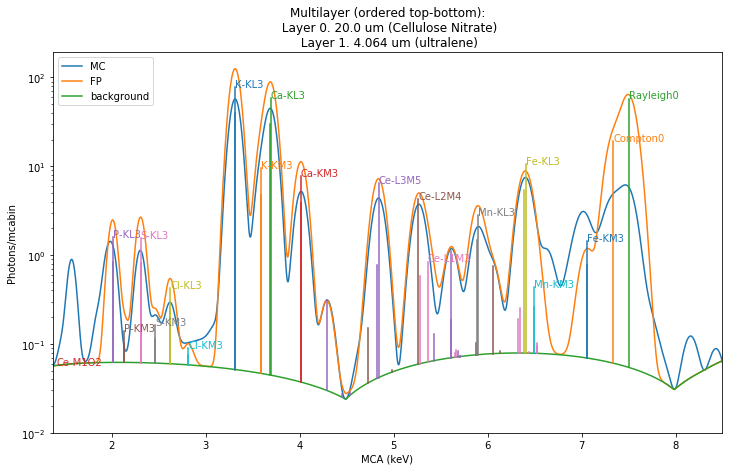

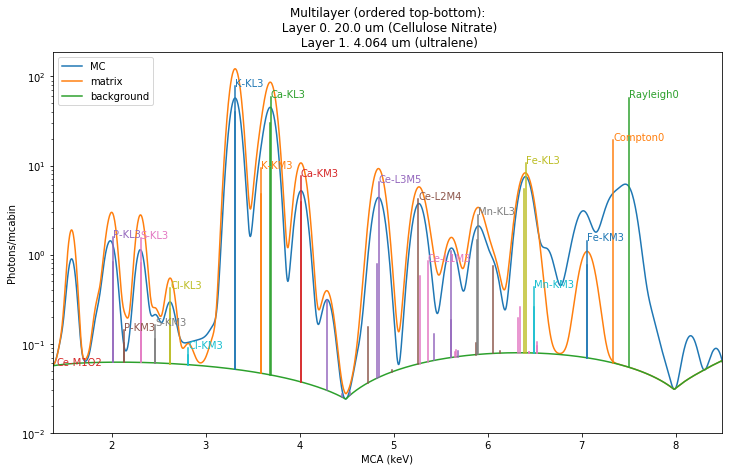

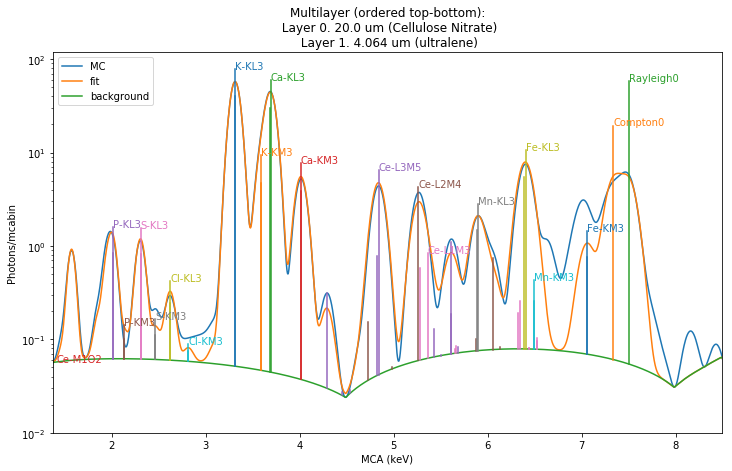

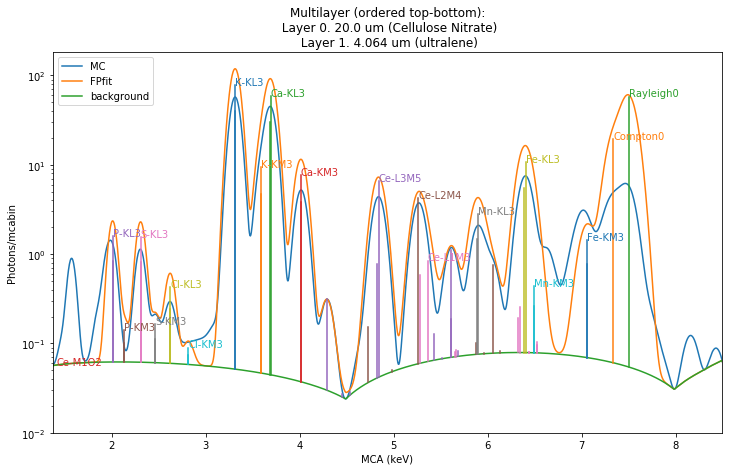

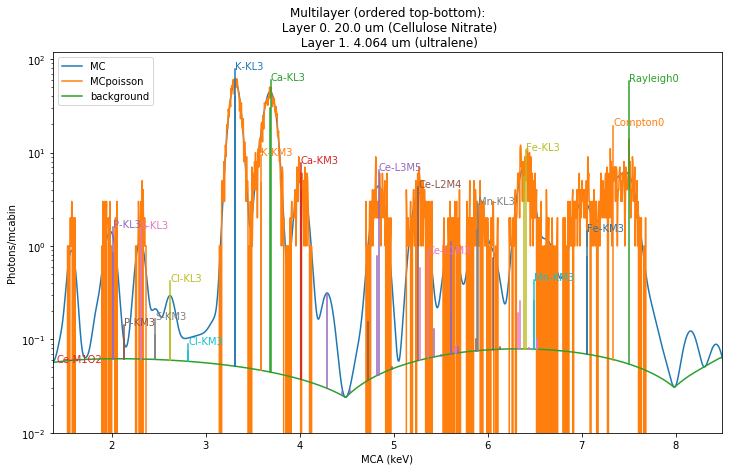

In [18]:
from contextlib import contextmanager

if 'xrfdl' in experiments:
    ylog = True
    
    @contextmanager
    def plotcontext():
        plt.figure(figsize=(12,7))
        plt.plot(spectra['MC']['energy'], spectra['MC']['mca'], label='MC')
        yield
        plt.plot(fitresult["energy"], fitresult["yback"], label='background')
        spectrumfit.plot(legend=False,
                         forcelines=True,
                         **spectrumkwargs)
        plt.legend()
        ax = plt.gca()
        if ylog:
            #y = spectra['MC']['mca']
            #y = y[np.nonzero(y)].min()
            ax.set_yscale('log', basey=10)
            ax.set_ylim(bottom=1e-2)
        #ax.set_xlim([3.5, 4.5])
        ax.set_xlabel('MCA (keV)')
        ax.set_ylabel('Photons/mcabin')
    
    printsummary(pymcahandle)
    for name, data in spectra.items():
        if name == 'MC':
            continue
        with plotcontext():
            plt.plot(data['energy'], data['mca'], label=name)

Save XRF spectra

In [19]:
from spectrocrunch.io.mca import save as savemca

def savepymcacfg(root, pymcahandle, name='fit'):
    try:
        os.makedirs(root)
    except OSError:
        pass
    filename = os.path.join(root, name+'.cfg')
    pymcahandle.savepymca(filename)
    print(filename)

def savespectra(root, spectra):
    try:
        os.makedirs(root)
    except OSError:
        pass
    for name, data in spectra.items():
        filename = os.path.join(root, name+'.mca')
        zero = data['energy'][0]
        gain = data['energy'][1]-zero
        savemca(data['mca'], filename, mode='w',
                zero=zero, gain=gain)
        print(filename)
            
if 'xrfdl' in experiments:
    printsummary(pymcahandle)
    savespectra(world.main.path, spectra)
    savepymcacfg(world.main.path, pymcahandle)

Multilayer (ordered top-bottom):
 Layer 0. 20.0 um (Cellulose Nitrate)
 Layer 1. 4.064 um (ultralene)
Energy = 7.5 
Flux = 1.0e+10 Hz
Time = 0.1 s
/users/denolf/xrmcdata/xrfdl/FP.mca
/users/denolf/xrmcdata/xrfdl/MC.mca
/users/denolf/xrmcdata/xrfdl/matrix.mca
/users/denolf/xrmcdata/xrfdl/fit.mca
/users/denolf/xrmcdata/xrfdl/FPfit.mca
/users/denolf/xrmcdata/xrfdl/MCpoisson.mca
/users/denolf/xrmcdata/xrfdl/fit.cfg


Calculate quality measures

Multilayer (ordered top-bottom):
 Layer 0. 20.0 um (Cellulose Nitrate)
 Layer 1. 4.064 um (ultralene)
Energy = 7.5 
Flux = 1.0e+10 Hz
Time = 0.1 s

Ce:
 signal = 2.45 cts
 noise = 2.81 cts
 noise/signal = 42.07%
 theory = 199.412026726 ppm
 theory = 2418.11385327 wppm
 fit = 1312.20695131 wppm (0.54 x theory)
 Ce-L3M5:
  FP = 1.65 x MC
  Matrix = 2.11 x MC
  FPfit = 1.66 x MC


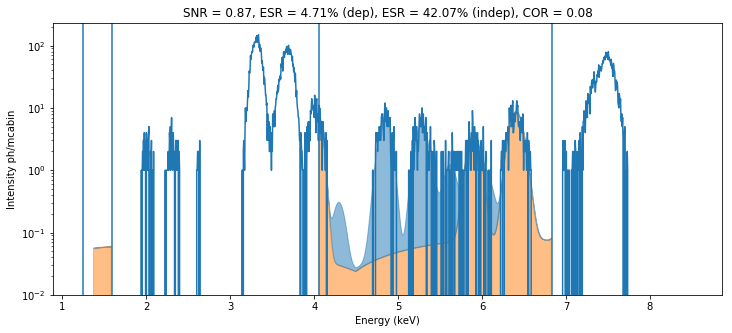

In [20]:
if 'xrfdl' in experiments:
    # Define by name:
    #lines = [["Ca-K"], ["La-L"]]
    # Or define by element and energy-range
    def getfluolines(ele, emin, emax):
        lines = xrayspectrum.FluoLine.factory(energybounds=(ele, emin, emax))
        return list([ele+'-'+str(line) for line in lines])
    emin,emax = pymcahandle.emin, pymcahandle.emax
    lines = [getfluolines(el, emin, emax) for el in elements]

    def SNR(spectrum, lines, plot=True, plotlines=False, ylog=True):
        def linevalid(ln):
            return any(ln.startswith(str(line)) for line in lines)
        ret = spectrum.snr(linevalid,
                           plot=plot,
                           kstd=4,
                           **spectrumkwargs)
        if plotlines and plot:
            spectrum.plot(forcelines=True,
                          title=None,
                          legend=False,
                          ylog=True,
                          **spectrumkwargs)
        elif ylog:
            plt.gca().set_yscale('log', basey=10)
        if ylog:
            plt.gca().set_ylim(bottom=0.01)
        #plt.xlim((1,3))
        return ret
    
    printsummary(pymcahandle)
    nfrac = pymcahandle.sample.elemental_molefractions()
    wfrac = pymcahandle.sample.elemental_massfractions()
    wfit = fitresult['massfractions']
    for sublines in lines:
        plt.figure(figsize=(12,5))
        ele = element.Element(sublines[0].split('-')[0])
        result = SNR(spectrum, sublines)
        wfracele = wfrac[ele]
        wfitele = np.nan
        for k, v in wfit.items():
            if k.element == ele:
                wfitele = v
        wfiterr = wfitele/wfracele
        print('\n{}:'.format(ele))
        print(' signal = {:.02f} cts'.format(result['signal']))
        print(' noise = {:.02f} cts'.format(result['noise']))
        print(' noise/signal = {:.02f}%'.format(result['ESR (independent)']*100))
        print(' theory = {} ppm'.format(nfrac[ele]*1e6))
        print(' theory = {} wppm'.format(wfracele*1e6))
        print(' fit = {} wppm ({:.02f} x theory)'.format(wfitele*1e6, wfiterr))
        
        sublines = [ele.fluolines(line.split('-')[1]) for line in sublines]
        i = np.argmax([spectrum[line] for line in sublines])
        maxline = sublines[i]
        energy = maxline.energy()
        fpi = np.argmin(np.abs(spectra['FP']['energy']-energy))
        mci = np.argmin(np.abs(spectra['MC']['energy']-energy))
        matrixi = np.argmin(np.abs(spectra['matrix']['energy']-energy))
        print(' {}:'.format(maxline))
        err = spectra['FP']['mca'][fpi]/spectra['MC']['mca'][mci]
        print('  FP = {:.02f} x MC'.format(err))
        err = spectra['matrix']['mca'][matrixi]/spectra['MC']['mca'][mci]
        print('  Matrix = {:.02f} x MC'.format(err))
        err = spectra['FPfit']['mca'][fpi]/spectra['MC']['mca'][mci]
        print('  FPfit = {:.02f} x MC'.format(err))
        plt.show()

## XRF: multi element <a class="anchor" id="xrf-multi"></a>

In [21]:
def multielement_geometry(world, name):
    # Origin: where beam hits the sample surface
    # Detector reference point: perpendicular projection of origin on detector surface
    # Distance, Polar, Azimuth: spherical coordinates of the detector reference point
    #   Azimuth = 0: in-plane and on the right (looking upstream)
    #   Azimuth = 180: in-plane and on the left (looking upstream)
    # Offset: shift detector center from reference point
    world.quadrics.polar = 0
    world.quadrics.azimuth = 0
    
    if name == 'leia':
        # Sample is rotate to the left when looking upstream
        world.quadrics.polar = 90-62
        world.quadrics.azimuth = 180
        pulseproctime = -np.log(1-0.8)/1e6  # 80%DT at 1e6 counts/sec
        det1 = {'name':'det1', 'activearea':0.8, 'distance':5.5,
                'polar':90+21, 'azimuth':0,
                'hoffset':0, 'voffset':0,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        return [det1]
    
    elif name == '1sgx80':
        # 1 SGX on the right when looking upstream
        pulseproctime = -np.log(1-0.8)/1e6  # 80%DT at 1e6 counts/sec
        det1 = {'name':'det1', 'activearea':0.8, 'distance':3,
                'polar':90+17, 'azimuth':0,
                'hoffset':0, 'voffset':0,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        return [det1]
    
    elif name == '2sgx80':
        # SGX on the left and on the right
        pulseproctime = -np.log(1-0.8)/1e6  # 80%DT at 1e6 counts/sec
        det1 = {'name':'det1', 'activearea':0.8, 'distance':3,
                'polar':90+16, 'azimuth':0,
                'hoffset':0, 'voffset':0,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        det2 = {'name':'det2', 'activearea':0.8, 'distance':3,
                'polar':90+16, 'azimuth':180,
                'hoffset':0, 'voffset':0,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        return [det1, det2]
    
    elif name == '3elflat':
        # flat 3 element detector
        activearea = 0.3  # cm^2
        Relement = np.sqrt(activearea/np.pi)
        shift = 0.7  # cm
        distance = 3.  # cm
        pulseproctime = -np.log(1-0.4)/1e6  # 40%DT at 1e6 counts/sec
        
        det1 = {'name':'top', 'activearea':activearea, 'distance':distance,
                'polar':90+16, 'azimuth':0,
                'hoffset':0, 'voffset':shift,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        det2 = {'name':'middle', 'activearea':activearea, 'distance':distance,
                'polar':90+16, 'azimuth':0,
                'hoffset':0, 'voffset':0,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        det3 = {'name':'bottom', 'activearea':activearea, 'distance':distance,
                'polar':90+16, 'azimuth':0,
                'hoffset':0, 'voffset':-shift,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        
        fig, ax = plt.subplots()
        c1 = plt.Circle((det1['hoffset'], det1['voffset']), radius=Relement,
                        clip_on=True, fill=True, color='b')
        c2 = plt.Circle((det2['hoffset'], det2['voffset']), radius=Relement,
                        clip_on=True, fill=True, color='b')
        c3 = plt.Circle((det3['hoffset'], det3['voffset']), radius=Relement,
                        clip_on=True, fill=True, color='b')
        ax.add_artist(c1)
        ax.add_artist(c2)
        ax.add_artist(c3)
        ax.set_xlim((-1.5*shift, 1.5*shift))
        ax.set_ylim((-2*shift, 2*shift))
        ax.set_aspect('equal')
        ax.set_title(name+' (looking at detector)')
        ax.set_xlabel('Detector (horizontal)')
        ax.set_ylabel('Detector (vertical)')
        
        return [det1, det2, det3]
    
    elif name == '2x3elflat':
        # flat 3 element detector
        activearea = 0.3  # cm^2
        Relement = np.sqrt(activearea/np.pi)
        shift = 0.7  # cm
        distance = 3.  # cm
        pulseproctime = -np.log(1-0.4)/1e6  # 40%DT at 1e6 counts/sec
        
        det1 = {'name':'top', 'activearea':activearea, 'distance':distance,
                'polar':90+16, 'azimuth':0,
                'hoffset':0, 'voffset':shift,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        det2 = {'name':'middle', 'activearea':activearea, 'distance':distance,
                'polar':90+16, 'azimuth':0,
                'hoffset':0, 'voffset':0,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        det3 = {'name':'bottom', 'activearea':activearea, 'distance':distance,
                'polar':90+16, 'azimuth':0,
                'hoffset':0, 'voffset':-shift,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        det4 = {'name':'top', 'activearea':activearea, 'distance':distance,
                'polar':90+16, 'azimuth':180,
                'hoffset':0, 'voffset':shift,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        det5 = {'name':'middle', 'activearea':activearea, 'distance':distance,
                'polar':90+16, 'azimuth':180,
                'hoffset':0, 'voffset':0,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        det6 = {'name':'bottom', 'activearea':activearea, 'distance':distance,
                'polar':90+16, 'azimuth':180,
                'hoffset':0, 'voffset':-shift,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        
        fig, ax = plt.subplots()
        c1 = plt.Circle((det1['hoffset'], det1['voffset']), radius=Relement,
                        clip_on=True, fill=True, color='b')
        c2 = plt.Circle((det2['hoffset'], det2['voffset']), radius=Relement,
                        clip_on=True, fill=True, color='b')
        c3 = plt.Circle((det3['hoffset'], det3['voffset']), radius=Relement,
                        clip_on=True, fill=True, color='b')
        ax.add_artist(c1)
        ax.add_artist(c2)
        ax.add_artist(c3)
        ax.set_xlim((-1.5*shift, 1.5*shift))
        ax.set_ylim((-2*shift, 2*shift))
        ax.set_aspect('equal')
        ax.set_title(name+' (looking at detector)')
        ax.set_xlabel('Detector (horizontal)')
        ax.set_ylabel('Detector (vertical)')
        
        return [det1, det2, det3, det4, det5, det6]
    
    elif name == '3elcentric':
        # centric 3 element detector
        # Equation of tangent going through [xp ,yp]
        #  xp*x + yp*y = R^2
        #  xp = R*cos(az)
        #  yp = R*sin(az)
        #  cos(az)*x + sin(az)*y = R
        # Intersection [xq,yp] with tangent through [R, 0]
        #  xq = R
        #  yq = R*(1-cos(az))/sin(az)
        # Distance between p and q should be shift/2
        #  d = sqrt((xq-xp)^2 + (yq-yp)^2)
        #    = R*sqrt((1-cos(az))/(1+cos(az)))
        #  cos(az) = (R**2-d**2)/(R**2+d**2)
        activearea = 0.3  # cm^2
        Relement = np.sqrt(activearea/np.pi)
        distance = 3.  # cm
        shift = 0.7 # 2*Relement
        d = shift/2.
        azimuth = np.degrees(np.arccos((distance**2-d**2)/(distance**2+d**2)))
        pulseproctime = -np.log(1-0.4)/1e6  # 40%DT at 1e6 counts/sec
        
        det1 = {'name':'top', 'activearea':activearea, 'distance':distance,
                'polar':90+17, 'azimuth':180-azimuth,
                'hoffset':0, 'voffset':0,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        det2 = {'name':'middle', 'activearea':activearea, 'distance':distance,
                'polar':90+17, 'azimuth':180,
                'hoffset':0, 'voffset':0,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        det3 = {'name':'bottom', 'activearea':activearea, 'distance':distance,
                'polar':90+17, 'azimuth':azimuth-180,
                'hoffset':0, 'voffset':0,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        
        fig, ax = plt.subplots()
        def genpoints(azimuth):
            az = np.radians(azimuth)
            sinaz, cosaz = np.sin(az), np.cos(az)
            x0, y0 = distance*cosaz, distance*sinaz
            if sinaz:
                u = np.array([(1-cosaz), (1-cosaz)/sinaz-sinaz])
            else:
                u = np.array([0, 1])
            ux, uy = u/np.sqrt(u.dot(u))
            x1, y1 = x0+ux*Relement, y0+uy*Relement
            x2, y2 = x0-ux*Relement, y0-uy*Relement
            return [x1, x0, x2], [y1, y0, y2]
        plt.plot(*genpoints(det1['azimuth']), color='b')
        plt.plot(*genpoints(det2['azimuth']), color='b')
        plt.plot(*genpoints(det3['azimuth']), color='b')
        p = distance*np.cos(np.radians(det2['azimuth']))
        ax.set_xlim((p-shift, p+shift))
        ax.set_ylim((-2*shift, 2*shift))
        ax.set_aspect('equal')
        ax.set_title(name+' (looking upstream)')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        
        return [det1, det2, det3]
    
    elif name == '4quadback':
        # flat 4 element detector in back-scattering geometry
        Router = 1.34/2  # cm
        Rinner = 0.18/2  # cm
        activearea = 0.15  # cm^2
        distance = 0.3  # cm
        Relement = np.sqrt(activearea/np.pi)
        shift = Router/(2*np.sqrt(2))
        pulseproctime = -np.log(1-0.9)/1e6  # 90%DT at 1e6 counts/sec
        
        det1 = {'name':'top1', 'activearea':activearea, 'distance':distance,
                'polar':180, 'azimuth':0,
                'hoffset':shift, 'voffset':shift,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        det2 = {'name':'top2', 'activearea':activearea, 'distance':distance,
                'polar':180, 'azimuth':0,
                'hoffset':-shift, 'voffset':shift,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        det3 = {'name':'bottom1', 'activearea':activearea, 'distance':distance,
                'polar':180, 'azimuth':0,
                'hoffset':shift, 'voffset':-shift,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        det4 = {'name':'bottom2', 'activearea':activearea, 'distance':distance,
                'polar':180, 'azimuth':0,
                'hoffset':-shift, 'voffset':-shift,
                'pixelshape':'elliptical',
                'pulseproctime': pulseproctime}
        
        fig, ax = plt.subplots()
        outer = plt.Circle((0, 0), radius=Router, clip_on=True, fill=False, linestyle='-')
        inner = plt.Circle((0, 0), radius=Rinner, clip_on=True, fill=True, color='k')
        c1 = plt.Circle((det1['hoffset'], det1['voffset']), radius=Relement,
                        clip_on=True, fill=True, color='b')
        c2 = plt.Circle((det2['hoffset'], det2['voffset']), radius=Relement,
                        clip_on=True, fill=True, color='b')
        c3 = plt.Circle((det3['hoffset'], det3['voffset']), radius=Relement,
                        clip_on=True, fill=True, color='b')
        c4 = plt.Circle((det4['hoffset'], det4['voffset']), radius=Relement,
                        clip_on=True, fill=True, color='b')
        ax.add_artist(outer)
        ax.add_artist(inner)
        ax.add_artist(c1)
        ax.add_artist(c2)
        ax.add_artist(c3)
        ax.add_artist(c4)
        ax.set_xlim((-Router, Router))
        ax.set_ylim((-Router, Router))
        ax.set_aspect('equal')
        ax.set_title(name+' (looking upstream)')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        
        return [det1, det2, det3, det4]
    
    else:
        return []

Monte-carlo simulation of one XRF spectrum

Multilayer (ordered top-bottom):
 Layer 0. 20.0 um (Cellulose Nitrate)
 Layer 1. 4.064 um (ultralene)
Energy = 7.5 
Flux = 1.0e+10 Hz
Time = 0.1 s


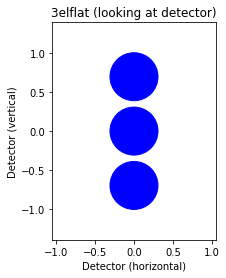

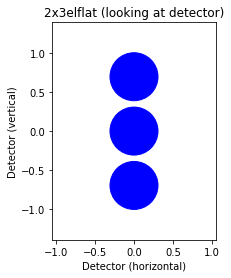

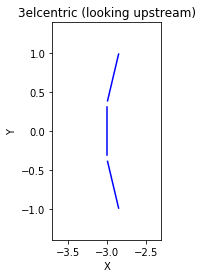

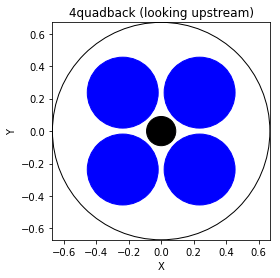

/users/denolf/xrmcdata/spectra/plant/leia_det1.cfg
leia_det1 OCR = 4.3e+03 cts
/users/denolf/xrmcdata/spectra/plant/leia_det1poisson.mca
/users/denolf/xrmcdata/spectra/plant/leia_sum.mca
/users/denolf/xrmcdata/spectra/plant/leia_sumpoisson.mca
/users/denolf/xrmcdata/spectra/plant/leia_det1.mca
/users/denolf/xrmcdata/spectra/plant/1sgx80_det1.cfg
1sgx80_det1 OCR = 1.0e+04 cts
/users/denolf/xrmcdata/spectra/plant/1sgx80_sum.mca
/users/denolf/xrmcdata/spectra/plant/1sgx80_det1poisson.mca
/users/denolf/xrmcdata/spectra/plant/1sgx80_sumpoisson.mca
/users/denolf/xrmcdata/spectra/plant/1sgx80_det1.mca
/users/denolf/xrmcdata/spectra/plant/2sgx80_det1.cfg
2sgx80_det1 OCR = 1.0e+04 cts
/users/denolf/xrmcdata/spectra/plant/2sgx80_det2.cfg
2sgx80_det2 OCR = 9.8e+03 cts
/users/denolf/xrmcdata/spectra/plant/2sgx80_sum.mca
/users/denolf/xrmcdata/spectra/plant/2sgx80_det2poisson.mca
/users/denolf/xrmcdata/spectra/plant/2sgx80_det1.mca
/users/denolf/xrmcdata/spectra/plant/2sgx80_det2.mca
/users/denolf/

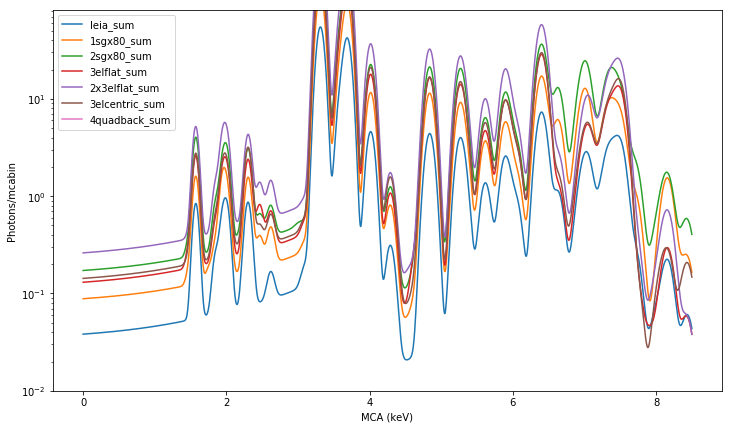

In [22]:
def plotsum(spectra, name):
    #plt.plot(spectra[name+'poisson']['energy'], spectra[name+'poisson']['mca'], label=name+'poisson')
    plt.plot(spectra[name]['energy'], spectra[name]['mca'], label=name)
    plt.legend()
    plt.xlabel('MCA (keV)')
    plt.ylabel('Photons/mcabin')
    ax = plt.gca()
    ax.set_yscale('log', basey=10)
    ax.set_ylim(bottom=1e-2)

def savesample(sample, filename):
    with open(filename, 'w') as f:
        f.write(str(sample) + '\n')
        for layer in sample:
            f.write('Elemental mass fractions of \'{}\':\n'.format(layer.material))
            fracs = layer.material.elemental_massfractions()
            for k,v in fracs.items():
                f.write(' {}: {}\n'.format(k, v))

if 'xrfmulti' in experiments:
    # MODIFY:
    samplename = 'plant'
    configs = ['leia', '1sgx80', '2sgx80', '3elflat', '2x3elflat', '3elcentric', '4quadback']
    #configs = ['4quadback']
    
    path = os.path.join(root, 'xrfmulti')
    result = os.path.join(root, 'spectra')
    world = XrmcWorldBuilder(path)
    source, pymcahandle = define_source()
    geometry = define_xrfgeometry(source=source)
    pymcahandle.ninteractions = 1
    pymcahandle.sample = define_sample(geometry, name=samplename)
    printsummary(pymcahandle)
    world_addsource(world, pymcahandle)
    world_addsdd(world, geometry,
                 multiplicity=10,
                 convoluted=True)
    world_addsample(world, pymcahandle.sample)
    world.quadrics.polar = 0
    multiplicity = (0,) + (10000,) * pymcahandle.ninteractions
    
    configs = [(cfgname,multielement_geometry(world, cfgname)) for cfgname in configs]
    plt.show()
    plt.figure(figsize=(12,7))
    for cfgname, detectors in configs:
        spectra = {}
        sumname = cfgname + '_' + 'sum'
        for detector in detectors:
            world.detector.polar = detector['polar']
            world.detector.azimuth = detector['azimuth']
            world.detector.hoffset = detector['hoffset']
            world.detector.voffset = detector['voffset']
            world.detector.activearea = detector['activearea']
            world.detector.distance = detector['distance']
            world.detector.pixelshape = detector['pixelshape']
            pulseproctime = detector['pulseproctime']
            world.detector.set_pulseproctime(None, None, pulseproctime=pulseproctime)
            # Only correct for centric cone geometry:
            geometry.distance = detector['distance']
            geometry.detector.activearea = detector['activearea']
            geometry.anglenormin = 0
            geometry.anglenormout = detector['polar']
            geometry.azimuth = detector['azimuth']

            data, info = run(world, multiplicity, plot=False)
            mca = data[:, 0, 0, 0, :].sum(axis=0)
            mcawnoise = addnoise(mca)
            energy = info['xenergy']

            detname = cfgname + '_' + detector['name']
            spectra[detname] = {'mca': mca, 'energy': energy}
            spectra[detname+'poisson'] = {'mca': mcawnoise, 'energy': energy}
            if sumname in spectra:
                spectra[sumname]['mca'] += mca
                spectra[sumname+'poisson']['mca'] += mcawnoise
            else:
                spectra[sumname] = {'mca': mca.copy(), 'energy': energy}
                spectra[sumname+'poisson'] = {'mca': mcawnoise.copy(), 'energy': energy}
            savepymcacfg(os.path.join(result, samplename), pymcahandle, name=detname)
            print('{} OCR = {:.1e} cts'.format(detname,mca.sum()))
        savespectra(os.path.join(result, samplename), spectra)
        plotsum(spectra, sumname)
    ax = plt.gca()
    ax.relim()
    ax.autoscale_view()
    plt.savefig(os.path.join(result, samplename+'.png'), dpi=300)
    savesample(pymcahandle.sample, os.path.join(result, samplename+'.txt'))